In [5]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from numpy import array
from math import sqrt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import keras.backend as K
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kruskal, shapiro, levene
import seaborn as sns
from random import random
#!pip install pmdarima --quiet
import pmdarima as pm

# Code adapted from https://medium.com/data-science/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# Plot data to view
def plot_data(df, feature):
    plt.figure(figsize=(15,7))
    plt.title(str(feature)+" by Month")
    plt.xlabel('Month')
    plt.ylabel(str(feature))
    plt.plot(df)
    plt.show()

#Determine rolling statistics to find trends
def rolling_statistics(df):
    df["rolling_avg"] = df[df.columns[0]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    df["rolling_std"] = df[df.columns[0]].rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#379BDB', label='Original')
    plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
    plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Augmented Dickey-Fuller Test to test if the time series is stationary
#If ADF has p <= 0.05, data are stationary
def ADF(df, feature):
    print('Results of Dickey Fuller Test for '+feature+':')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

#Standard ARIMA Model
def fit_ARIMA_model(y, y_val, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(12):
        for q in range(12):
            # Check RMSE for each fold
            cv_errors = []
            cv_mae = []
            cv_mape = []
            cv_r2 = []
            for k in range(5):
                series = pd.Series(y[k])
                
                model = pm.ARIMA(add_padding(y[k]), order=(p, 0, q), suppress_warnings=True)
                
                model_fit = model.fit(add_padding(y_val[k]))
                print(model_fit.summary())

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))

    model = ARIMA(add_padding(y[k]), order=(best_p, 0, best_q))
    
    return model

#Standard ARIMA Model
def fit_auto_ARIMA_model(y, y_val, n_seq):

    # Check RMSE for each fold
    cv_errors = []
    cv_mae = []
    cv_mape = []
    cv_r2 = []
    for k in range(5):

        model = pm.auto_arima(add_padding(y[k]), start_p=0, start_q=0, test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='warn', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model_fit = model.fit(add_padding(y_val[k]))
        print(model_fit.summary())

        series = pd.Series(val_y[k])

        #Make predictions
        predictions = model_fit.predict(start=len(val_y[k][-n_seq]), end=len(series)-1)

        # Get actual values to compare against predictions
        actual = []
        for i in range(len(y_val[0])):
            x2 = y_val[0]
            y2=x2[i]
            a = 178-n_seq
            z2 = []
            for j in reversed(range(n_seq)):
                z2.append(y2[178-j])
            if n_seq == 1:
                actual.append(z2[0])
            else:
                actual.append(z2)
                    
        #Calculate the Root Mean Square Error (RMSE)
        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        mape = mean_absolute_percentage_error(actual, predictions)
        r2 = r2_score(actual, predictions)
        cv_errors.append(rmse)
        cv_mae.append(mae)
        cv_mape.append(mape)
        cv_r2.append(r2)

    print("RMSE values for ARIMA model:")
    print(cv_errors)
            
    # Print evaluation results
    print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
    print(f"Mean Absolute Error: {np.mean(cv_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
    print(f"R2 Score: {np.mean(cv_r2)}")

    return model
    
# SARIMAX Model
def fit_SARIMAX_model(X, y, X_val, y_val, exog, n_seq, seasonal_order):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(12):
        for q in range(12):
            # Check RMSE for each fold
            cv_errors = []
            cv_mae = []
            cv_mape = []
            cv_r2 = []
            for k in range(5):
                series = pd.Series(y[k])
    
                model = pm.ARIMA(add_padding(y[k]), exogenous=exog, order=(p, 0, q), seasonal_order=seasonal_order)                         

                model_fit = model.fit(add_padding(y_val[k]))
                print(model_fit.summary())

                # Taken from https://medium.com/pythons-gurus/multi-step-forecasting-with-arima-predicting-long-term-climate-trends-291e5e08c2a2
                # Number of steps to forecast
                forecast_steps = n_seq

                # Perform multi-step forecasting
                forecast = model_fit.get_forecast(steps=forecast_steps)
                forecast_values = forecast.predicted_mean
                confidence_intervals = forecast.conf_int()

                # Plot the results
                plt.figure(figsize=(14, 7))
                plt.plot(data.index, data['Temperature'], label='Observed Temperature')
                forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
                plt.plot(forecast_index, forecast_values, label='Forecasted Temperature', linestyle='--')
                plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
                plt.title('Multi-step Temperature Forecast')
                plt.xlabel('Month')
                plt.ylabel('Temperature')
                plt.legend()
                plt.show()

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for SARIMAX model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))

    model = SARIMAX(add_padding(y[k]), exogenous=exog, order=(best_p, 0, best_q), seasonal_order=seasonal_order)
        
    return model

# SARIMAX Model
def fit_auto_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        PC1_list = PC1[k]
        PC2_list = PC2[k]
        PC3_list = PC3[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])
            exog1 = np.array(PC1_list[j])
            exog2 = np.array(PC2_list[j])
            exog3 = np.array(PC3_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

            # Define the exogenous variables
            exog = data[['exog1', 'exog2', 'exog3']]

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model

def plot_diagnostics(model):
    model.plot_diagnostics(figsize=(15,12))
    plt.show
    
def ARIMA_forecast(ARIMA_model, df, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make a series for plotting purposes
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

def SARIMAX_forecast(SARIMAX_model, df, exog, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=exog)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))

# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into training sets
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        train.append([scaled_values_batch])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([scaled_values_batch])
        else:
            validation.append([scaled_values_batch])
    
    return validation, test

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))

def transform_data(data, n_lag, n_seq):
    
    X_row = []
    y_row = []
    temp_row = []
    sh_row = []
    PC1_row = []
    PC2_row = []
    PC3_row = []
    for j in range(len(data)):
        X2 = data[j]
        y2 = pd.DataFrame(X2[n_seq:n_lag+n_seq])
        X_row.append(pd.DataFrame(X2[:n_lag]))
        temp_row.append(X_row[j][X_row[j].columns[0]])
        sh_row.append(X_row[j][X_row[j].columns[1]])
        PC1_row.append(X_row[j][X_row[j].columns[2]])
        PC2_row.append(X_row[j][X_row[j].columns[3]])
        PC3_row.append(X_row[j][X_row[j].columns[4]])
        y_row.append(y2[y2.columns[0]])

    return X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row

#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])

#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])

train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10

#X1 = slp	
#X2 = wbt	
#X3 = water	
#X4 = GHI
#X5 = WDSP
#X6 = PRCP	
#X7 = SNDP	
#X8 = Region	
#X9 = SA	
#X10 = ONI

# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['date', 'latitude', 'longitude', 'elevation'], axis=1)

results_df = df_trimmed

# Calculate principal components excluding response variables
results_df['PC1']=-0.0004514*results_df['slp']+0.03194*results_df['wet_bulb_temperature']-0.04343*results_df['water']+0.002243*results_df['GHI']-0.02252*results_df['WDSP']
+0.9877*results_df['PRCP']-0.2265*results_df['SNDP']+0.006144*results_df['region']-0.0001488*results_df['solar_activity']+0.02943*results_df['ONI']
results_df['PC2']=0.0001702*results_df['slp']+0.005484*results_df['wet_bulb_temperature']+0.2057*results_df['water']-0.0003188*results_df['GHI']-0.02584*results_df['WDSP']
+1.6963*results_df['PRCP']-0.05890*results_df['SNDP']+0.05809*results_df['region']+1.9748*results_df['solar_activity']+0.03686*results_df['ONI']
results_df['PC3']=-0.00006323*results_df['slp']-0.001180*results_df['wet_bulb_temperature']-0.02384*results_df['water']-0.00002833*results_df['GHI']+0.01170*results_df['WDSP']
+0.5204*results_df['PRCP']+0.4791*results_df['SNDP']-0.004318*results_df['region']+0.008271*results_df['solar_activity']+0.8765*results_df['ONI']

# Drop columns that compose principal components
results_df = results_df.drop(['slp', 'wet_bulb_temperature', 'water', 'GHI', 'WDSP', 'PRCP', 'SNDP', 'region', 'solar_activity', 'ONI'], axis=1)

print(results_df)

print(results_df.columns)

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = results_df[results_df['file_id'] == i].drop(['file_id', 'Year', 'Month'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and n_vars features 
train_y = [] # Holds 5 folds, each with 84 different weather stations, 227 time steps, and 1 feature (response variable)
val_X = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and n_vars features 
val_y = [] # Holds 5 folds, each with 21 different weather stations, 227 time steps, and 1 feature (response variable)
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
        val_X_rows.append(X[j])
        val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows)

#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)    

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])

    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
       file_id  temperatures  specific_humidity    Year  Month       PC1  \
0         6501         12.21               5.39  2006.0    1.0 -0.155299   
1         6501          8.17               4.30  2006.0    2.0 -0.193200   
2         6501         15.68               6.51  2006.0    3.0  0.093451   
3         6501         22.46              10.21  2006.0    4.0  0.456252   
4         6501         23.66              11.74  2006.0    5.0  0.566777   
...        ...           ...                ...     ...    ...       ...   
24057     9858         28.60              15.21  2024.0    7.0       NaN   
24058     9858         29.11              15.15  2024.0    8.0       NaN   
24059     9858         24.57              10.72  2024.0    9.0       NaN   
24060     9858         21.16               6.99  2024.0   10.0       NaN   
24061     9

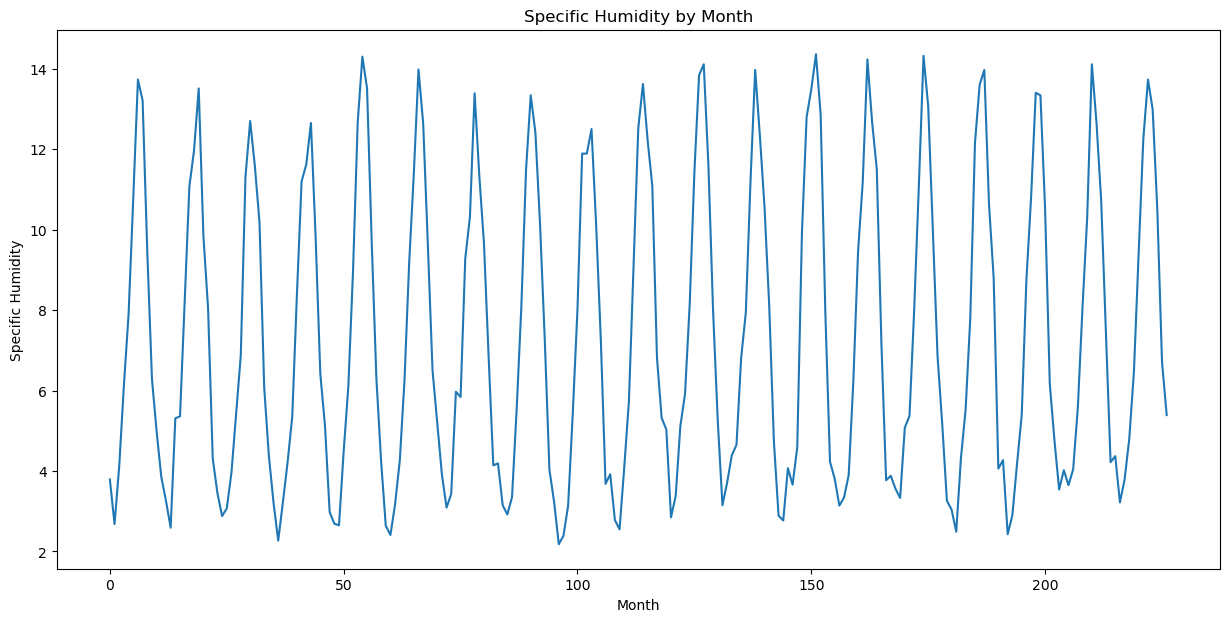

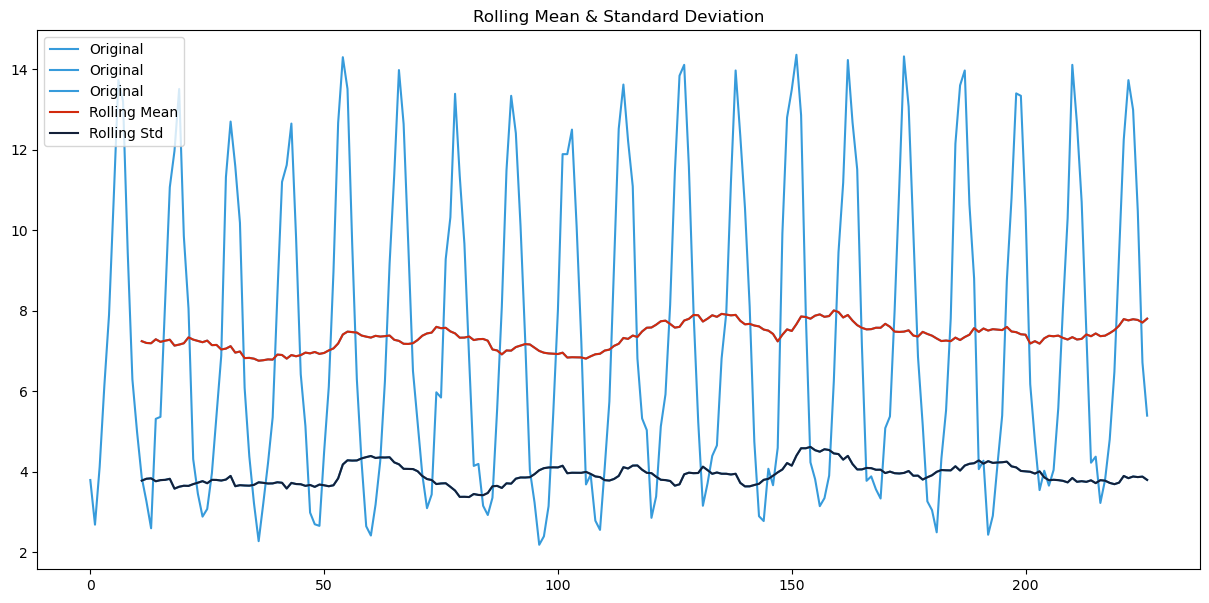

Results of Dickey Fuller Test for Specific Humidity:
Test Statistic                -1.530093e+01
p-value                        4.313806e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
Results of Dickey Fuller Test for Specific Humidity:
Test Statistic                  -1.978146
p-value                          0.296237
#Lags Used                      11.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64
5610.541277532282
0.0
Shapiro-Wilk Test for Normality:
{6501: 3.1185658008942296e-09, 6541: 8.182414265776978e-11, 6640: 2.2746835035919295e-08, 6668: 1.197829815588906e-09, 6678: 2.815654475596797e-08, 6687: 1.5005855461937291e-09, 6697: 8.272123076160461e-12, 

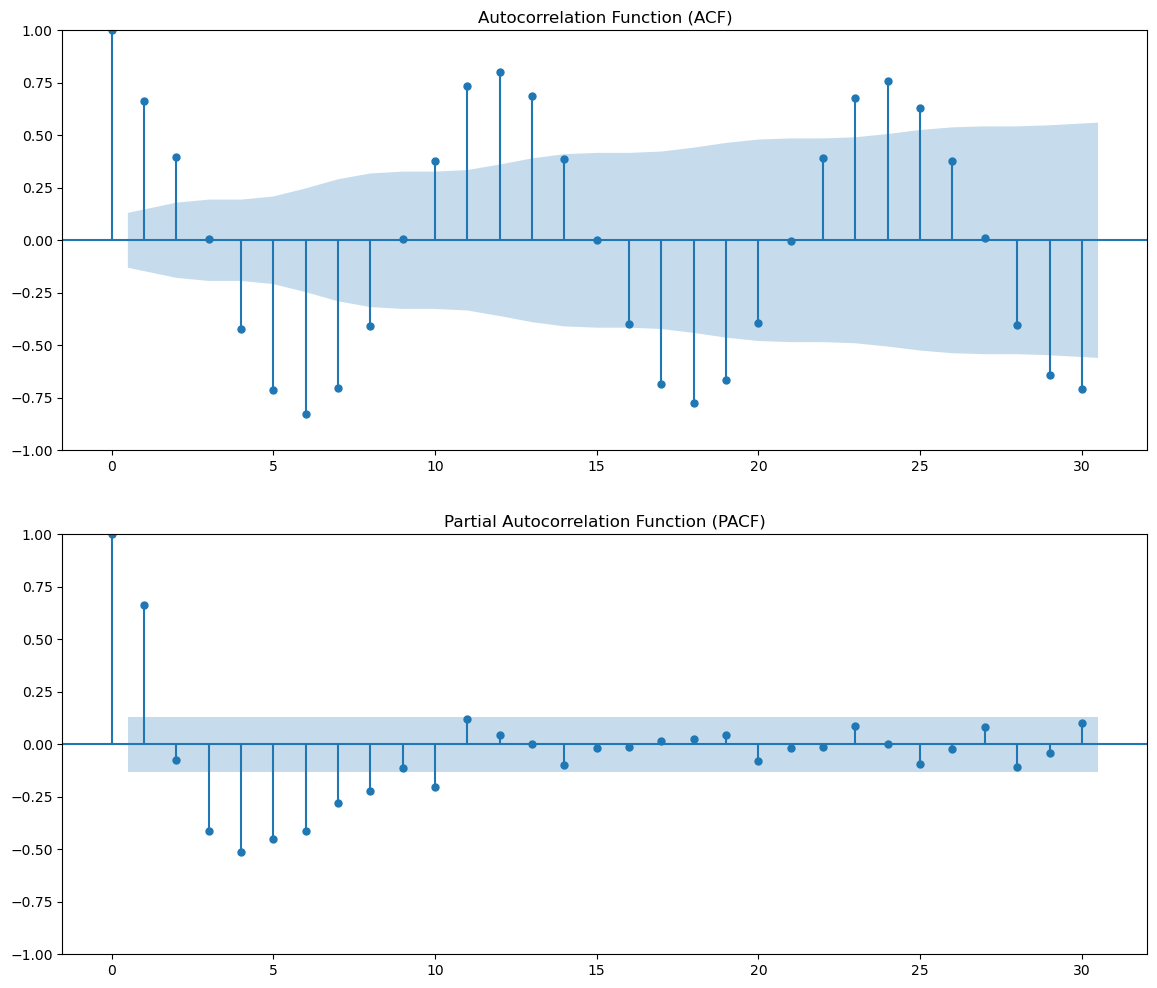

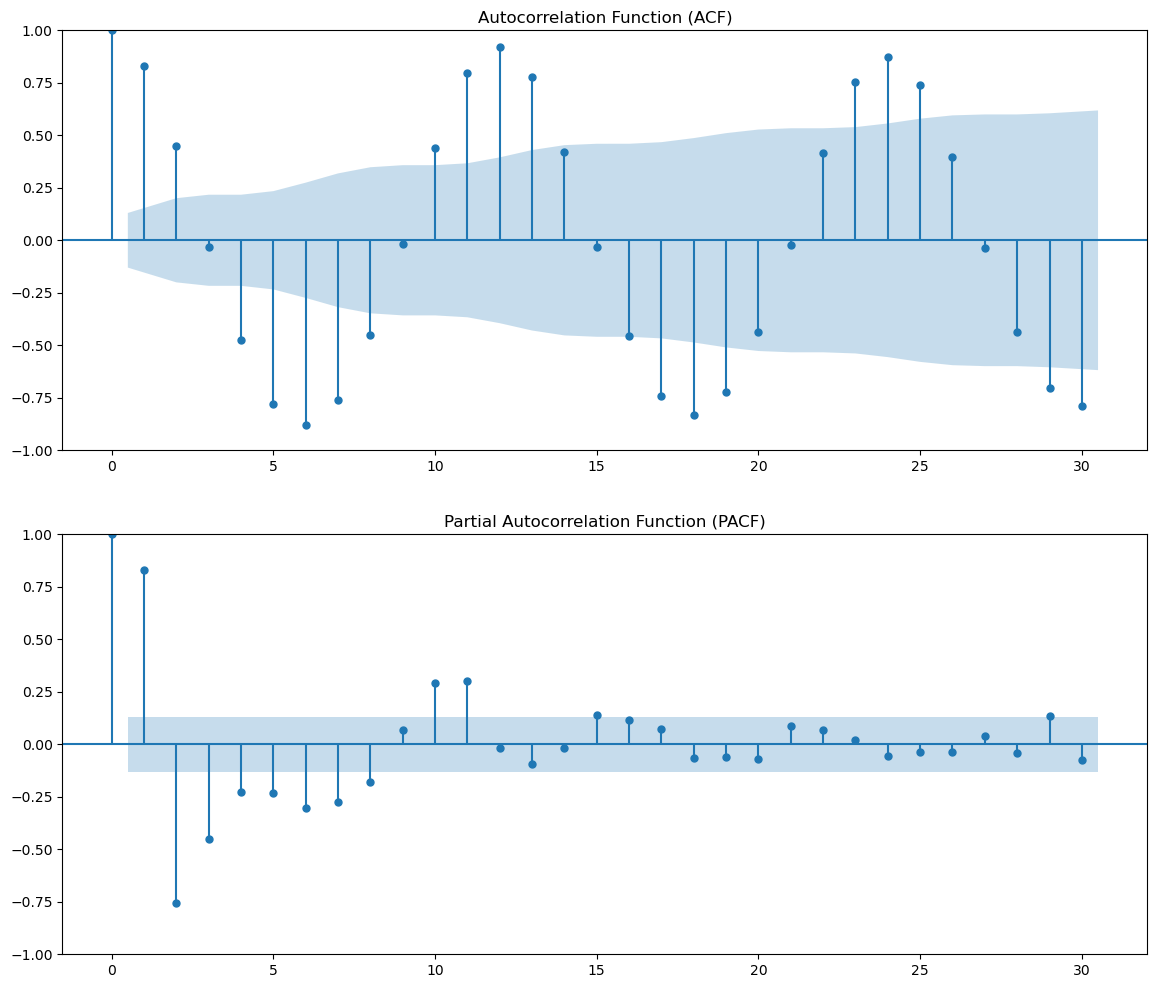

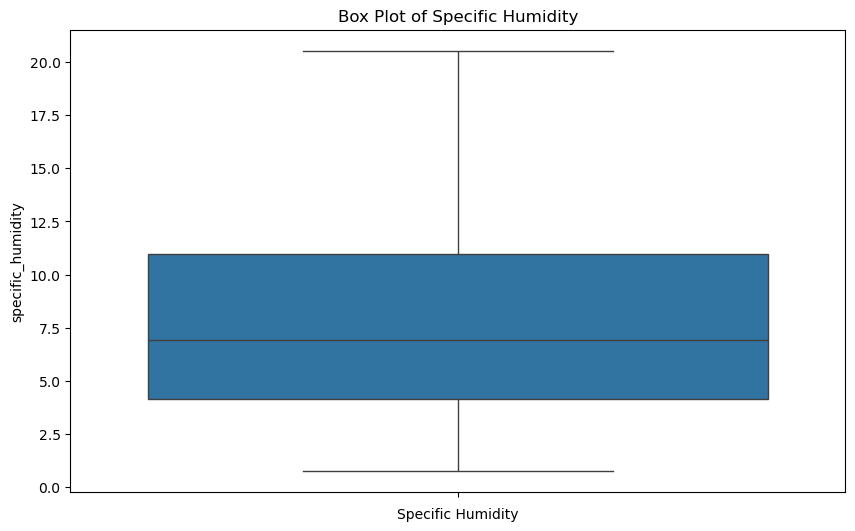

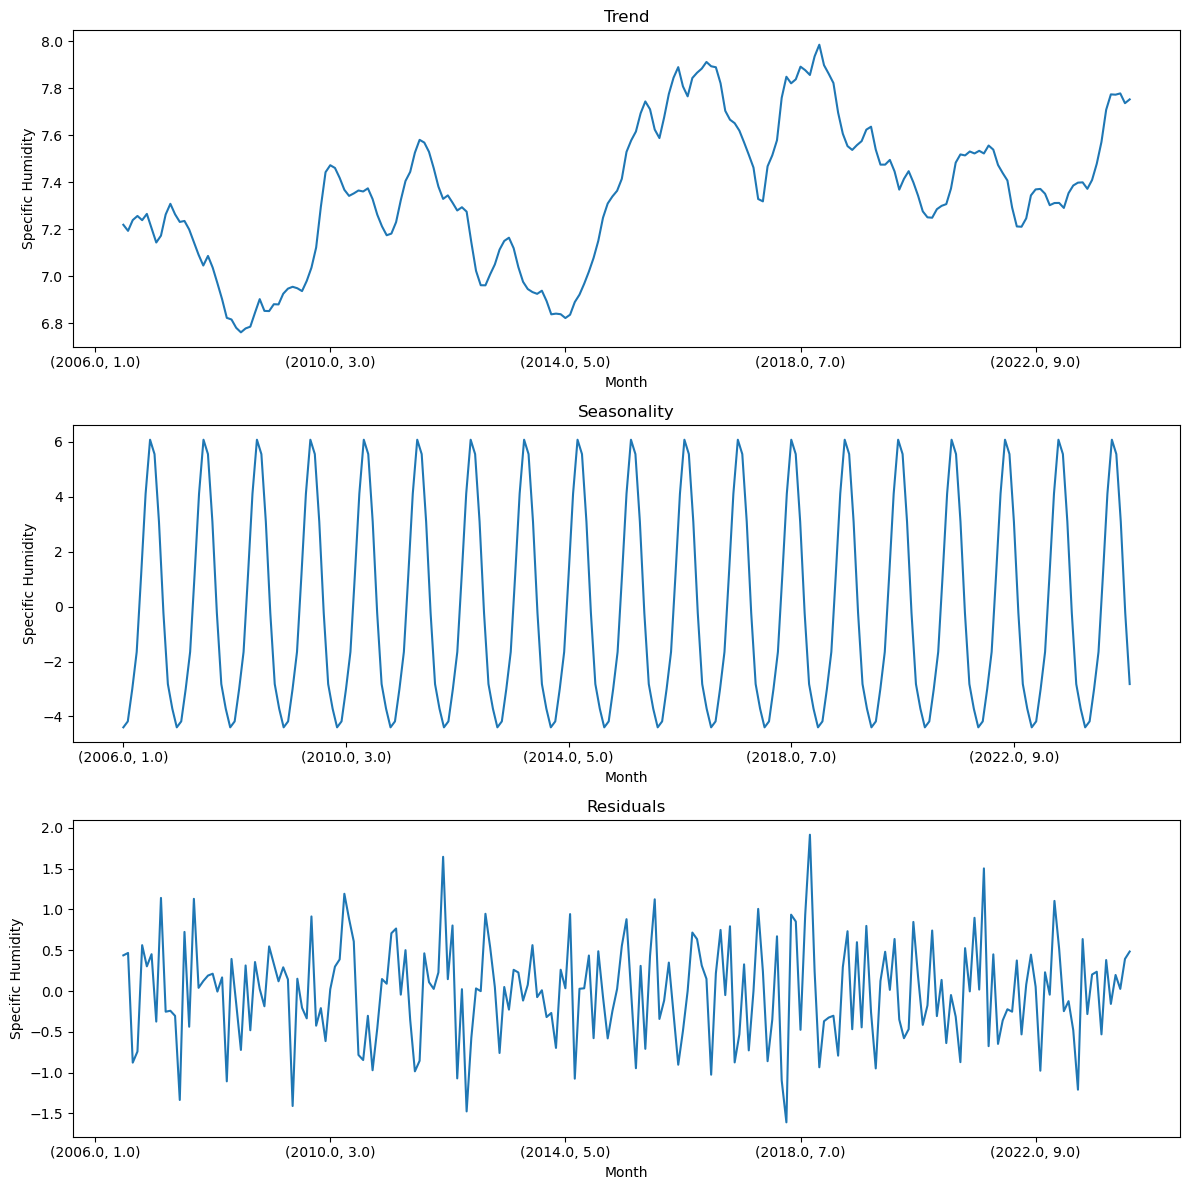

In [6]:
def ADF(df, feature):
    print('Results of Dickey Fuller Test for '+feature+':')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station specific humidity for each month
y_df = results_df.groupby(['Year', 'Month'])['specific_humidity'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (specific humidity)
    data.append(ws_row) # Get single weather station's specific humidity

# Aggregate the transformed data by getting the median of the weather station specific humidity for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's specific humidity for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Specific Humidity")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Specific Humidity")
ADF(y1, "Specific Humidity")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['specific_humidity'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['specific_humidity'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['specific_humidity'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['specific_humidity'])
plt.title('Box Plot of Specific Humidity')
plt.xlabel('Specific Humidity')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Specific Humidity')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Specific Humidity')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Specific Humidity')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

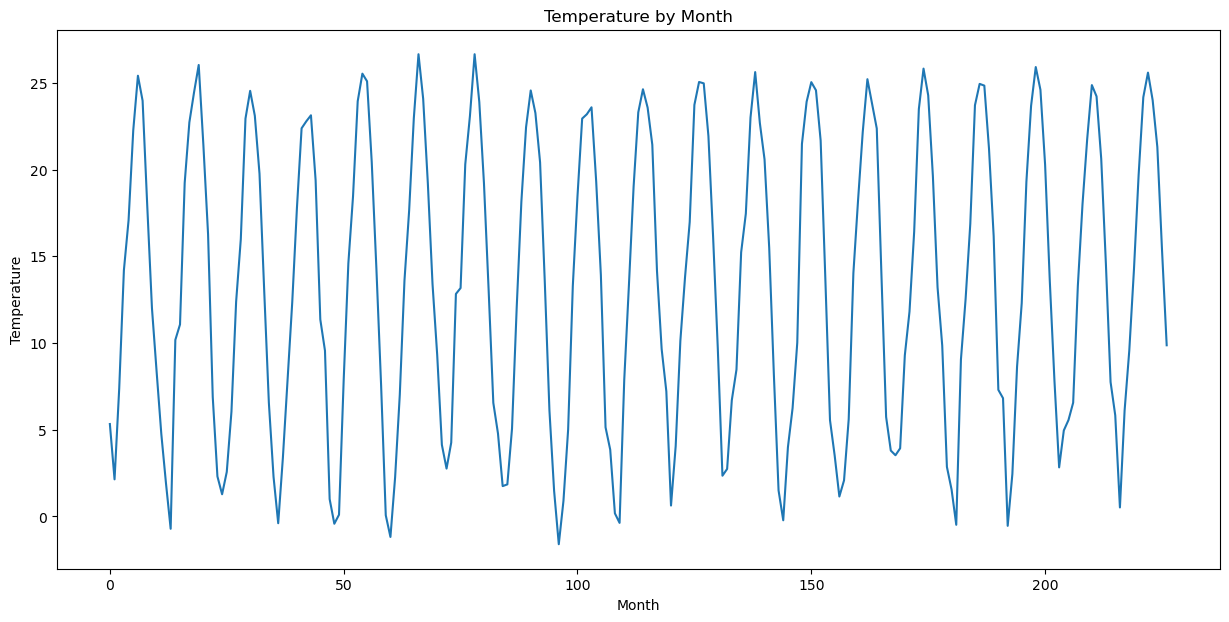

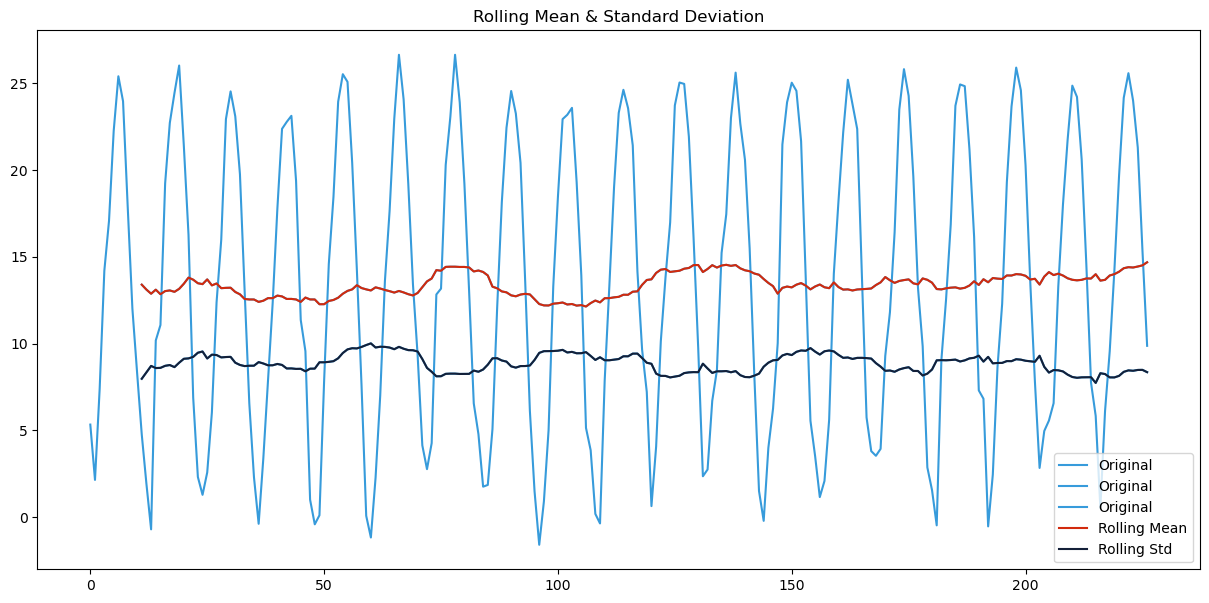

Results of Dickey Fuller Test for temperature:
Test Statistic                -1.530093e+01
p-value                        4.313806e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -1.961249
p-value                          0.303818
#Lags Used                      12.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
5023.1403397674585
0.0
Shapiro-Wilk Test for Normality:
{6501: 2.86869752185945e-08, 6541: 4.065203567402447e-08, 6640: 2.730287140314634e-09, 6668: 1.282499829012734e-08, 6678: 2.6395133105830528e-08, 6687: 1.9321912642995334e-08, 6697: 3.4535783214922218e-09, 6714: 5.4188

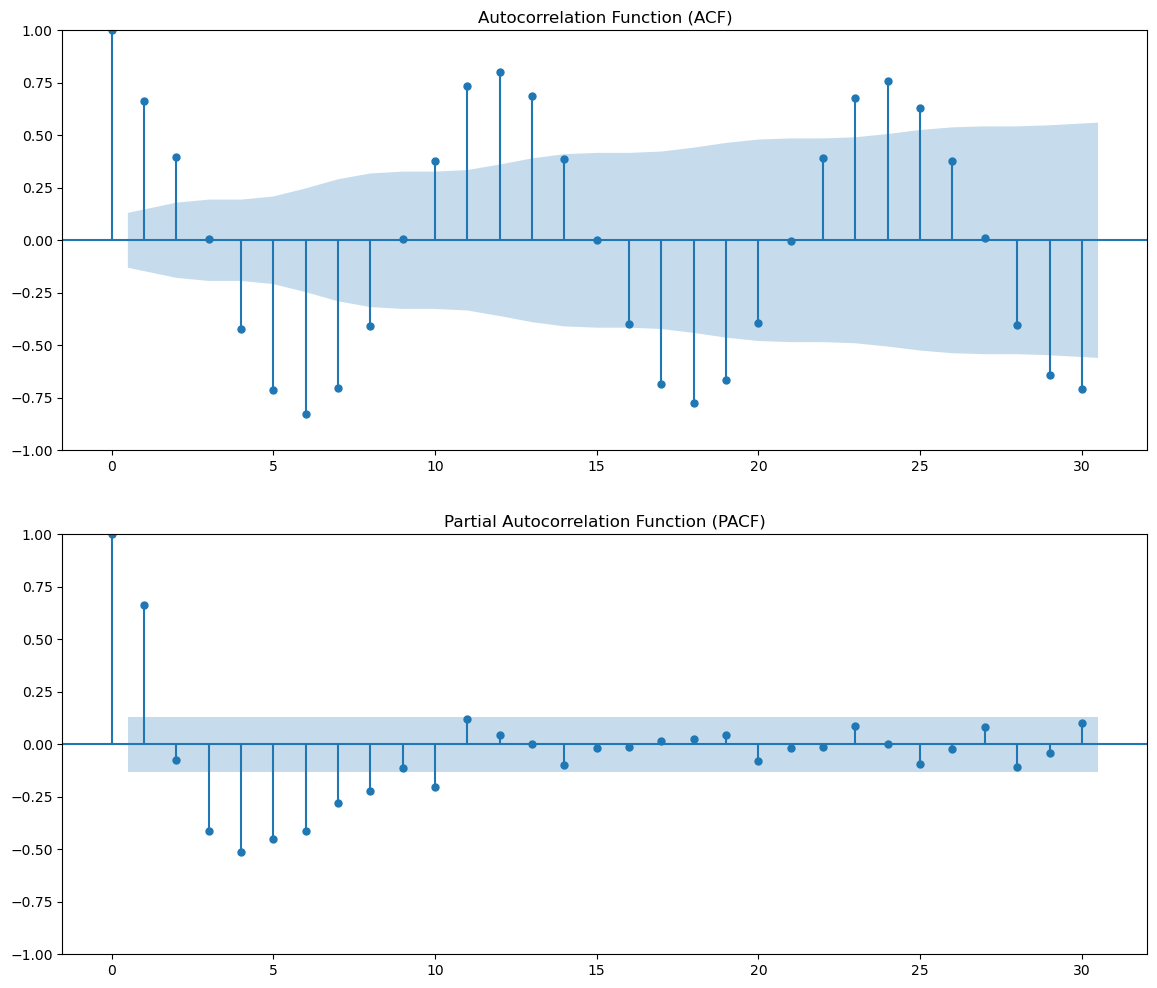

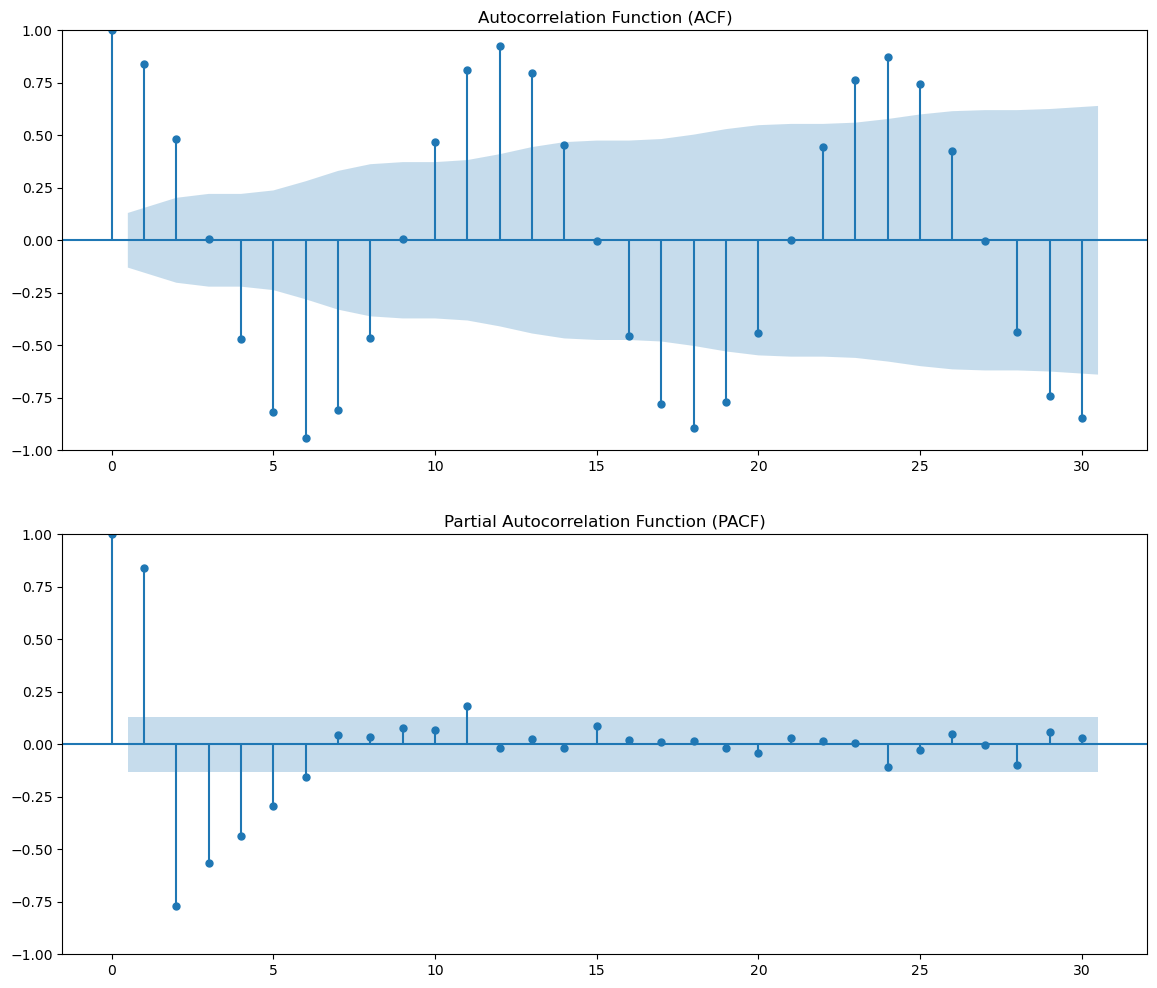

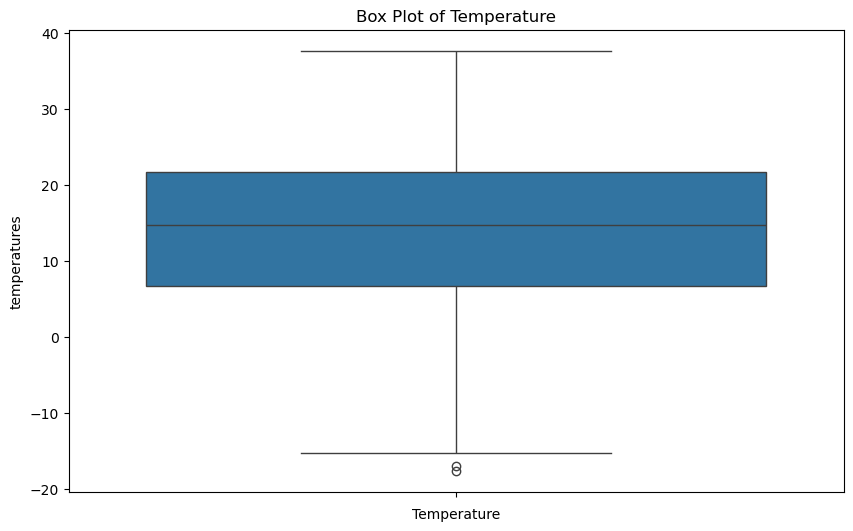

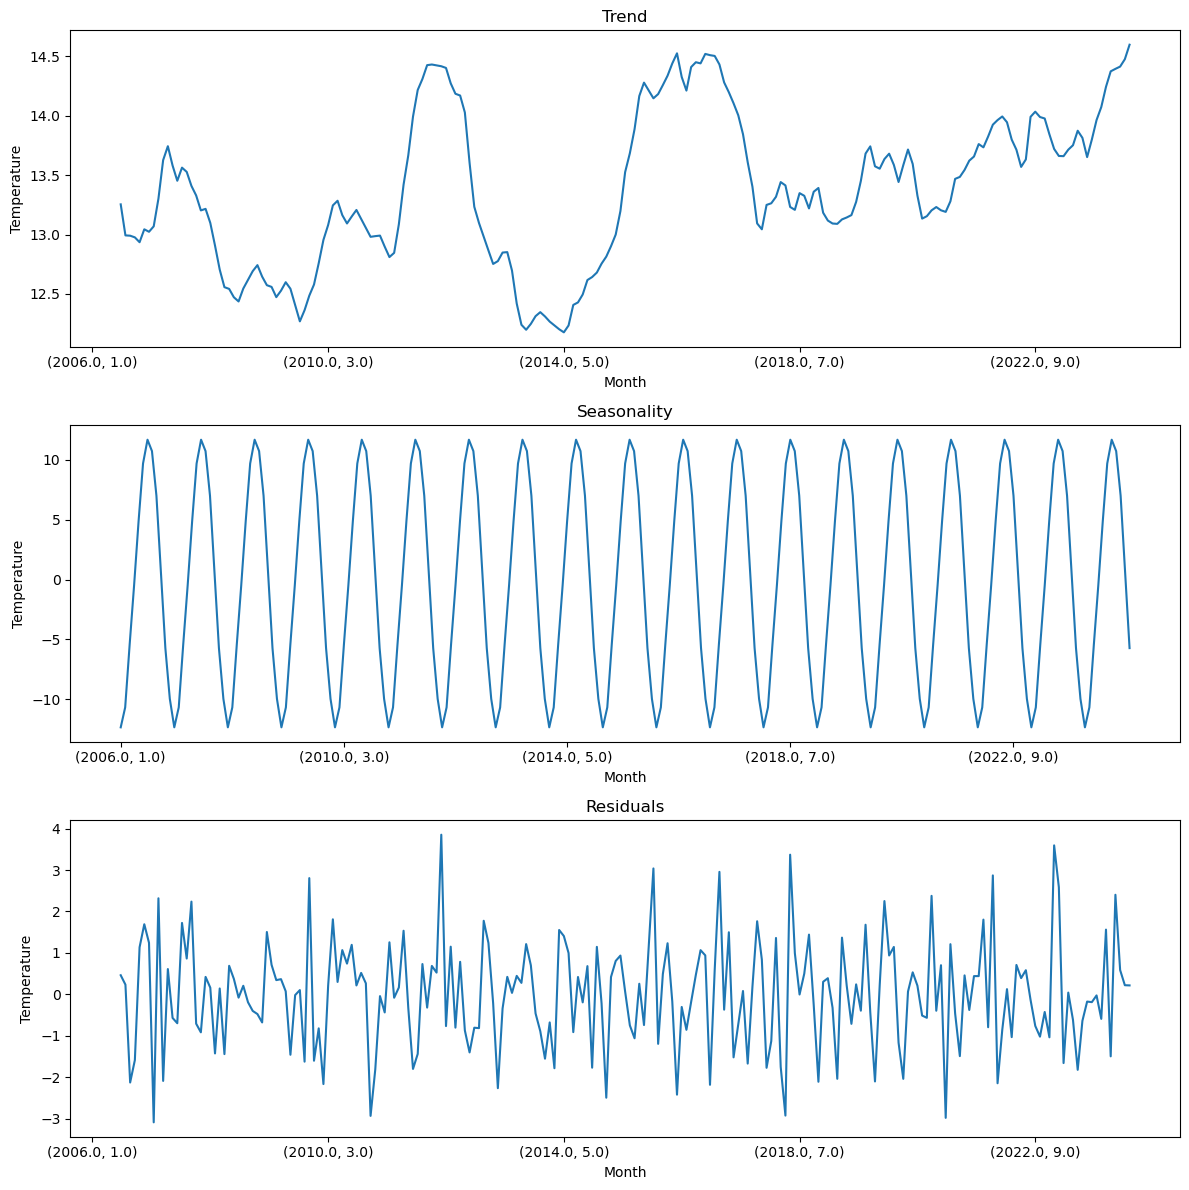

ARIMA Temperature Predictions:


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(12, 0, 4)   Log Likelihood                1442.105
Date:                Fri, 23 May 2025   AIC                          -2850.210
Time:                        02:52:06   BIC                          -2755.777
Sample:                             0   HQIC                         -2815.456
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6298      0.022     28.503      0.000       0.586       0.673
ar.L2          0.7498      0.036     20.778      0.000       0.679       0.821
ar.L3          0.0795      0.039      2.039      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(12, 0, 5)   Log Likelihood                1454.483
Date:                Fri, 23 May 2025   AIC                          -2872.966
Time:                        03:20:39   BIC                          -2772.979
Sample:                             0   HQIC                         -2836.167
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3398      0.064      5.313      0.000       0.214       0.465
ar.L2          0.6007      0.081      7.431      0.000       0.442       0.759
ar.L3          0.3745      0.055      6.864      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(9, 0, 4)   Log Likelihood                1454.309
Date:                Fri, 23 May 2025   AIC                          -2878.619
Time:                        04:05:19   BIC                          -2795.296
Sample:                             0   HQIC                         -2847.953
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0639      0.015      4.371      0.000       0.035       0.092
ar.L1          1.0979      0.024     45.225      0.000       1.050       1.145
ar.L2         -0.2431      0.035     -6.880      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(11, 0, 4)   Log Likelihood                1372.508
Date:                Fri, 23 May 2025   AIC                          -2711.016
Time:                        04:53:34   BIC                          -2616.583
Sample:                             0   HQIC                         -2676.261
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0753      0.013      5.653      0.000       0.049       0.101
ar.L1          0.6408      0.060     10.686      0.000       0.523       0.758
ar.L2          0.6806      0.087      7.780      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1910
Model:              SARIMAX(11, 0, 4)   Log Likelihood                1352.692
Date:                Fri, 23 May 2025   AIC                          -2673.383
Time:                        05:19:54   BIC                          -2584.506
Sample:                             0   HQIC                         -2640.673
                               - 1910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4201      0.075      5.572      0.000       0.272       0.568
ar.L2          1.1966      0.105     11.417      0.000       0.991       1.402
ar.L3         -0.2322      0.086     -2.697      0.0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [2]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

train1 = train[0]
test1 = test[0]
validation1 = validation[0]

# Aggregate the original data by getting the median of the weather station temperatures for each month
y_df = results_df.groupby(['Year', 'Month'])['temperatures'].median()
y1 = y_df.values

data = []
for j in range(len(train1)):
    ws_row = []
    for k in range(len(train1[0])):
        Q = train1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(test1)):
    ws_row = []
    for k in range(len(test1[0])):
        Q = test1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures
for j in range(len(validation1)):
    ws_row = []
    for k in range(len(validation1[0])):
        Q = validation1[j]
        R = Q[k]
        ws_row.append(R[0]) # get first column (temperature)
    data.append(ws_row) # Get single weather station's temperatures

# Aggregate the transformed data by getting the median of the weather station temperatures for each month
y_scaled = []

for j in range(len(data[0])):
    ws_row = [] # holds all 105 weather station's temperatures for the same time step to get median value
    for k in range(len(data)):
        ws_row.append(data[k][j])
    y_scaled.append(np.median(ws_row))

# Plot data
plot_data(y1, "Temperature")

#Get rolling statistics
rolling_statistics(pd.DataFrame(y1))

# Run Dickey-Fuller test to check if stationary
ADF(y_scaled, "Temperature")
ADF(y1, "Temperature")

#Run Kruskal-Wallis H Test to check if the population median of each weather station is the same
kruskal_stat, kruskal_pval = kruskal(*[results_df[results_df['file_id'] == f]['temperatures'] for f in results_df['file_id'].unique()])

print(kruskal_stat)
print(kruskal_pval)
    
#Run Shapiro-Wilk Test for normality
normality_test_results = {}
for ws in results_df['file_id'].unique():
    w, pvalue = shapiro(results_df[results_df['file_id'] == ws]['temperatures'])
    normality_test_results[ws] = pvalue
        
# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(*[results_df[results_df['file_id'] == ws]['temperatures'] for ws in results_df['file_id'].unique()])

print("Shapiro-Wilk Test for Normality:")
print(normality_test_results)
print("Levene's Test for Homogeneity of Variances:")
print(levene_stat)
print("Levene p: "+str(levene_p))

# Generate ACF and PACF plots
fig1, axes1 = plt.subplots(2, 1, figsize=(14, 12))

print("Scaled Data:")

# Plot ACF
plot_acf(pd.DataFrame(y_scaled), ax=axes1[0], lags=30, alpha=0.05)
axes1[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(pd.DataFrame(y_scaled), ax=axes1[1], lags=30, alpha=0.05, method='ywm')
axes1[1].set_title('Partial Autocorrelation Function (PACF)')

print("Unscaled Data:")

# Generate ACF and PACF plots
fig2, axes2 = plt.subplots(2, 1, figsize=(14, 12))

# Plot ACF
plot_acf(y_df, ax=axes2[0], lags=30, alpha=0.05)
axes2[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(y_df, ax=axes2[1], lags=30, alpha=0.05, method='ywm')
axes2[1].set_title('Partial Autocorrelation Function (PACF)')

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(y=results_df['temperatures'])
plt.title('Box Plot of Temperature')
plt.xlabel('Temperature')
plt.show()

# Decomposing the time series with an appropriate period based on the data's seasonality
decomposition_filled = seasonal_decompose(y_df, model='additive', period=12) # Monthly seasonality

# Plotting the decomposed components of the time series
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
decomposition_filled.trend.plot(ax=ax1)
ax1.set_title('Trend')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature')

decomposition_filled.seasonal.plot(ax=ax2)
ax2.set_title('Seasonality')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature')

decomposition_filled.resid.plot(ax=ax3)
ax3.set_title('Residuals')
ax3.set_xlabel('Month')
ax3.set_ylabel('Temperature')

plt.tight_layout()
plt.show()

# Transform data for ARIMA and SARIMAX

for i in range(5):

    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)

    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

# Run models
    
# Predict temperature

# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

print("ARIMA Temperature Predictions:")

auto_ARIMA_model = fit_auto_ARIMA_model(y, y_val, n_seq)

print(auto_ARIMA_model.summary())

In [45]:
# SARIMAX Model
def fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq):

    # Check RMSE for each fold
    cv1_errors = []
    cv1_mae = []
    cv1_mape = []
    cv1_r2 = []
    cv2_errors = []
    cv2_mae = []
    cv2_mape = []
    cv2_r2 = []

    dates = pd.date_range(start='2006-01-01', periods=179, freq='M')

    y1 = []
    y2 = []
    exog1 = []
    exog2 = []
    exog3 = []
    
    for k in range(5):
        y1_list = temp[k]
        y2_list = sh[k]
        y1_val = temp_val[k]
        y1_test = temp_test[k]
        y2_val = sh_val[k]
        y2_test = sh_test[k]
        PC1_list = PC1[k]
        PC2_list = PC2[k]
        PC3_list = PC3[k]
        for j in range(len(y1_list)):
            series1 = pd.Series(y1_list[j])
            series2 = pd.Series(y2_list[j])
            y1 = np.array(y1_list[j])
            y2 = np.array(y2_list[j])
            exog1 = np.array(PC1_list[j])
            exog2 = np.array(PC2_list[j])
            exog3 = np.array(PC3_list[j])

            # Reconstruct the data frame with standardized values
            data = pd.DataFrame({'y1': y1, 'y2': y2, 'exog1': exog1, 'exog2': exog2, 'exog3': exog3}, index=dates)

            # Define the exogenous variables
            exog = data[['exog1', 'exog2', 'exog3']]

            model1 = pm.auto_arima(y1, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )

            model2 = pm.auto_arima(y2, start_p=0, start_q=0, exogenous=exog, 
                              test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=True, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='ignore', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
            model1_fit = model1.fit(y1_val[0])
            print(model1_fit.summary())

            model2_fit = model2.fit(y2_val[0])
            print(model2_fit.summary())

            #Make predictions
            predictions1 = model1_fit.predict(start=len(y1_list[-n_seq]), end=len(series1)-1)

            #Make predictions
            predictions2 = model2_fit.predict(start=len(y2_list[-n_seq]), end=len(series2)-1)

            # Get actual values to compare against predictions
            actual1 = []
            for i1 in range(len(temp_val[k])):
                xtwo = y1_val[0]
                ztwo = []
                for c1 in reversed(range(n_seq)):
                    ztwo.append(xtwo[len(series1)-1-c1])
                if n_seq == 1:
                    actual1.append(ztwo[0])
                else:
                    actual1.append(ztwo)

            actual2 = []
            for i2 in range(10):
                xthree = y2_val[0]
                zthree = []
                for c2 in reversed(range(n_seq)):
                    zthree.append(xthree[len(series2)-1-c2])
                if n_seq == 1:
                    actual2.append(zthree[0])
                else:
                    actual2.append(zthree)

            print("Actuals:")
            print(actual1)
            print(actual2)
            print("Predicted:")
            print(predictions1)
            print(predictions2)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse1 = mean_squared_error(actual1, predictions1)
            rmse1 = np.sqrt(mse1)
            mae1 = mean_absolute_error(actual1, predictions1)
            mape1 = mean_absolute_percentage_error(actual1, predictions1)
            r2a = r2_score(actual1, predictions1)
            cv1_errors.append(rmse1)
            cv1_mae.append(mae1)
            cv1_mape.append(mape1)
            cv1_r2.append(r2a)

            #Calculate the Root Mean Square Error (RMSE)
            mse2 = mean_squared_error(actual2, predictions2)
            rmse2 = np.sqrt(mse2)
            mae2 = mean_absolute_error(actual2, predictions2)
            mape2 = mean_absolute_percentage_error(actual2, predictions2)
            r2b = r2_score(actual2, predictions2)
            cv2_errors.append(rmse2)
            cv2_mae.append(mae2)
            cv2_mape.append(mape2)
            cv2_r2.append(r2b)

            print("Weather Station "+str(j)+" Temperature RMSE value: "+str(rmse1))
            print("Weather Station "+str(j)+" Specific Humidity RMSE value: "+str(rmse2))        
        
        print("Fold "+str(k)+":")
        print("Temperature Metrics:")
        print("RMSE values:")
        print(cv1_errors)
        print("MAE values:")
        print(cv1_mae)
        print("MAPE values:")
        print(cv1_mape)
        print("R2 scores:")
        print(cv1_r2)
        print("")
        print("Specific Humidity Metrics:")
        print("RMSE values:")
        print(cv2_errors)
        print("MAE values:")
        print(cv2_mae)
        print("MAPE values:")
        print(cv2_mape)
        print("R2 scores:")
        print(cv2_r2)

    print("RMSE values for SARIMAX model:")
    print("Temperature:")
    print(cv1_errors)
    print("Specific Humidity:")
    print(cv2_errors)
            
    # Print evaluation results
    print("Temperature:")
    print("Average of RMSE fold values: "+str(np.mean(cv1_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv1_errors)))
    print(f"Mean Absolute Error: {np.mean(cv1_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv1_mape)}")
    print(f"R2 Score: {np.mean(cv1_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv1_errors)))
    print("Specific Humidity:")
    print("Average of RMSE fold values: "+str(np.mean(cv2_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv2_errors)))
    print(f"Mean Absolute Error: {np.mean(cv2_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv2_mape)}")
    print(f"R2 Score: {np.mean(cv2_r2)}")
    print("Best RMSE fold value: "+str(np.min(cv2_errors)))
    
    return model

SARIMAX_model = fit_SARIMAX_model(temp, temp_val, temp_test, sh, sh_val, sh_test, PC1, PC1_val, PC1_test, PC2, PC2_val, PC2_test, PC3, PC3_val, PC3_test, n_seq)

print(SARIMAX_model.summary())

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 169.633
Date:                                 Sun, 25 May 2025   AIC                           -323.266
Time:                                         22:10:44   BIC                           -297.766
Sample:                                              0   HQIC                          -312.926
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.007      0.326      0.745      -0.011       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  179
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood                 210.591
Date:                                 Sun, 25 May 2025   AIC                           -403.182
Time:                                         22:10:45   BIC                           -374.496
Sample:                                              0   HQIC                          -391.550
                                                 - 179                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.002      0.717      0.474      -0.002       0

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 203.052
Date:                              Sun, 25 May 2025   AIC                           -394.105
Time:                                      22:11:21   BIC                           -374.981
Sample:                                           0   HQIC                          -386.350
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.004      1.503      0.133      -0.002       0.015
ar.L1         -0.27

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  179
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 237.844
Date:                              Sun, 25 May 2025   AIC                           -463.688
Time:                                      22:11:21   BIC                           -444.563
Sample:                                           0   HQIC                          -455.933
                                              - 179                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.384      0.701      -0.001       0.001
ar.L1          0.14

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

KeyboardInterrupt: 

In [40]:
y1_val = temp_val[0]
print(y1_val[0])

0      0.445930
1      0.691981
2      0.743013
3      0.635480
4      0.697752
         ...   
174    0.507898
175    0.280680
176    0.248785
177    0.405832
178    0.250608
Name: 0, Length: 179, dtype: float64


In [14]:
# Taken from https://nandakishorej8.medium.com/auto-tuning-multiple-timeseries-sarimax-model-with-a-case-study-and-detailed-code-explanation-c136293b8457

#function returns dataframe with best parameters
def sarimax_gridsearch(ts,area,col,params, maxiter=5000):
    '''
    Input: 
        ts : your time series data
        area : areacode of the current model
        col : product category on which the model is being built
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Print and save out top parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''
# Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for i in range(0,len(params)):
        
        mod = SARIMAX(ts,
                      order=params[i][0],
                      seasonal_order=params[i][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
 
        output = mod.fit()
        ans.append([area,col,params[i][0][0],params[i][0][1],params[i][0][2], params[i][1][0],params[i][1][1],params[i][1][2],params[i][1][3],params[i][0],params[i][1], output.aic])
        print('SARIMAX {} x {} 12 : parameters {},{} AIC={} '.format(area,col,params[i][0], params[i][1], output.aic))
# Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['area','product','p','d','q', 'Ps','Ds','Qs','Ss','pdq','pdqs', 'aic'])
# Sort and return top  combination
    ans_df = ans_df.sort_values(by=['area','product','aic'],ascending=True)[0:1]
    
    return ans_df

best_param=pd.DataFrame() # --- Dataframe to store the best parameters for each area-product combination
prediction=pd.DataFrame() # -- Dataframe to store the predictins for next 16 months for each area-product combination
ans = []
par={} 
for t in area:
  data=df[df['areacode']==t]
  forecast=pd.DataFrame()
  temp={}
  for c in columns:
# STEP 1 - Calling function to get best paramaters for each area-product combination
    df_ans=sarimax_gridsearch(data[c],t,c,params)
# STEP 2 - Storing the best parameters for each area-product combination
    best_param=best_param.append(df_ans)
    best_param=best_param.sort_values(by=['area','product','aic'],ascending=True)
    
    print('for area {} and product {}'.format(t,c))
    print('best pdq is {}'.format(best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdq'].iloc[0]))
    print('best pdqs is {}'.format(best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdqs'].iloc[0]))
    
 # STEP 3- Building model with best parameters to make forecast for next 16 months   
    smx = SARIMAX(
            data[c],
            order=best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdq'].iloc[0],
            seasonal_order=best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdqs'].iloc[0],
            enforce_stationarity=False,
            enforce_invertibility=False
          )
    
    model = smx.fit()
    predictions = model.get_forecast(
        steps=steps
      ).predicted_mean
    
    df_forecast = pd.DataFrame(predictions)
    df_forecast.columns=[c]
    temp[c]=(best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdq'].iloc[0],best_param.loc[(best_param['area']==t) & (best_param['product']==c)]['pdqs'].iloc[0])
    
    forecast=pd.concat([forecast, df_forecast], axis=1)
forecast=forecast.fillna(0)
  forecast['area']=t
  par[t]=temp # -- storing the best parameters into dictionary . this is an optional step
  
#step 4- storing the forecast of next 16 months for each area-product combination
  prediction=pd.concat([prediction,forecast],axis=0)

IndentationError: unexpected indent (2115151258.py, line 78)

In [114]:
q=X[0]

exog = []

for j in range(len(q)):
    r=q[j]
    print(r)
    r = pd.DataFrame(r)
    r.columns = ['temp', 'sh', 'PC1', 'PC2', 'PC3']
    exog = r.drop(['temp'], axis=1)
    print(exog)

84
            0         1         2         3         4
0    0.393074  0.427250  0.499158  0.533339  0.387146
1    0.701397  0.630703  0.669098  0.530015  0.525306
2    0.755772  0.675709  0.827197  0.646887  0.322968
3    0.585358  0.625154  0.627050  0.704111  0.299277
4    0.663426  0.653514  0.717804  0.637181  0.337906
..        ...       ...       ...       ...       ...
174  0.439550  0.352035  0.452016  0.525320  0.463821
175  0.356318  0.323674  0.292577  0.481905  0.571750
176  0.258809  0.218866  0.186456  0.347340  0.680805
177  0.436817  0.457460  0.385407  0.499444  0.547458
178  0.279162  0.364365  0.355021  0.601679  0.351285

[179 rows x 5 columns]
         temp        sh       PC1       PC2       PC3
0    0.393074  0.427250  0.499158  0.533339  0.387146
1    0.701397  0.630703  0.669098  0.530015  0.525306
2    0.755772  0.675709  0.827197  0.646887  0.322968
3    0.585358  0.625154  0.627050  0.704111  0.299277
4    0.663426  0.653514  0.717804  0.637181  0.337906
.

In [124]:
print(len(sh[0][0]))

179


In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Standard ARIMA Model
def fit_ARIMA_model(y, y_val, y_test, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    p = 12 # ACF and auto_arima suggest AR should be 12
    for q in range(4, 13): # Looking for MA value
        # Check RMSE for each fold
        cv_errors = []
        cv_mae = []
        cv_mape = []
        cv_r2 = []
        print("p = "+str(p)+", q = "+str(q))
        for k in range(5):
            print("Fold "+str(k))
            series = pd.Series(y_test[k])
                
            model = SARIMAX(add_padding(y[k]), order=(12, 0, q))
                
            model_fit = model.fit(add_padding(y_val[k]))

            #Make predictions
            predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(y[k][-n_seq])+len(series)-1)

            print(predictions)

            # Get actual values to compare against predictions
            actual = []
            for i in range(len(y_test[k])):
                x2 = y_test[k]
                y2=x2[i]
                a = len(pd.Series(y_test[k][i]))-n_seq-1
                z2 = []
                for j in reversed(range(n_seq)):
                    z2.append(y2[178-j])
                if n_seq == 1:
                    actual.append(z2[0])
                else:
                    actual.append(z2)

            print(actual)
                    
            #Calculate the Root Mean Square Error (RMSE)
            mse = mean_squared_error(actual, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(actual, predictions)
            mape = mean_absolute_percentage_error(actual, predictions)
            r2 = r2_score(actual, predictions)
            cv_errors.append(rmse)
            cv_mae.append(mae)
            cv_mape.append(mape)
            cv_r2.append(r2)

        print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
        print(cv_errors)
            
        # Print evaluation results
        print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
        print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
        print(f"Mean Absolute Error: {np.mean(cv_mae)}")
        print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
        print(f"R2 Score: {np.mean(cv_r2)}")
        if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
            best_rmse = np.mean(cv_errors)
        if np.mean(cv_errors) < best_rmse:
            best_p = p
            best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))

    model = ARIMA(add_padding(y[k]), order=(best_p, 0, best_q))
    
    return model

ARIMA_model = fit_ARIMA_model(y, y_val, y_test, n_seq)

p = 12, q = 4
Fold 0


LinAlgError: Schur decomposition solver error.

In [92]:
print(y[0][-n_seq])
print(len(pd.Series(y[0][-n_seq]))-n_seq-1)

0      0.582928
1      0.605407
2      0.530680
3      0.570170
4      0.506379
         ...   
174    0.472053
175    0.477217
176    0.436817
177    0.352977
178    0.496962
Name: 0, Length: 179, dtype: float64
177


In [90]:
h = y_val[0]

print(len(pd.Series(h[0])))

179


In [45]:
#Standard ARIMA Model
def fit_auto_ARIMA_model(y, y_val, n_seq):

    # Check RMSE for each fold
    cv_errors = []
    cv_mae = []
    cv_mape = []
    cv_r2 = []
    for k in range(5):
        series = pd.Series(y[k])

        model = pm.auto_arima(add_padding(y[k]), start_p=0, start_q=0, test='adf', # use adftest to find optimal 'd' 
                              max_p=12, max_q=12, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                              d=None,# let model determine 'd'
                              seasonal=False, # No Seasonality for standard ARIMA
                              trace=False, #logs 
                              error_action='warn', #shows errors ('ignore' silences these)
                              suppress_warnings=True,
                              stepwise=True
                              )
                
        model_fit = model.fit(add_padding(y_val[k]))
        print(model_fit.summary())

        #Make predictions
        predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

        # Get actual values to compare against predictions
        actual = []
        for i in range(len(y_val[0])):
            x2 = y_val[0]
            y2=x2[i]
            a = 178-n_seq
            z2 = []
            for j in reversed(range(n_seq)):
                z2.append(y2[178-j])
            if n_seq == 1:
                actual.append(z2[0])
            else:
                actual.append(z2)

        print(actual)
        
        #Calculate the Root Mean Square Error (RMSE)
        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        mape = mean_absolute_percentage_error(actual, predictions)
        r2 = r2_score(actual, predictions)
        cv_errors.append(rmse)
        cv_mae.append(mae)
        cv_mape.append(mape)
        cv_r2.append(r2)

    print("RMSE values for ARIMA model:")
    print(cv_errors)
            
    # Print evaluation results
    print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
    print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
    print(f"Mean Absolute Error: {np.mean(cv_mae)}")
    print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
    print(f"R2 Score: {np.mean(cv_r2)}")

    return model




NameError: name 'actual' is not defined

In [54]:
# Get actual values to compare against predictions
actual = []
for i in range(len(y_val[0])):
    x2 = y_val[0]
    y2=x2[i]
    a = len(pd.Series(y[0][0]))-n_seq-1
    z2 = []
    for j in reversed(range(n_seq)):
        z2.append(y2[178-j])
    if n_seq == 1:
        actual.append(z2[0])
    else:
        actual.append(z2)

print(actual)
print(len(pd.Series(y[0][0]))-n_seq-1)
print(a)
print(len(y_val[0]))
print(len(pd.Series(y[0][0]))-1)

[0.514277035236938, 0.40613608748481167, 0.43560145808019446, 0.4210206561360875, 0.43469015795868776, 0.4753948967193196, 0.5154921020656137, 0.4286148238153099, 0.4878493317132443, 0.47721749696233295]
177
177
10
178


In [21]:
#Standard ARIMA Model
def ARIMA_best_model(y, y_val, n_seq, p, d, q):

    # Check rmse for each fold
    cv_errors = []
    cv_mae = []
    cv_mape = []
    cv_r2 = []
    for k in range(5):
        print("Fold "+str(k+1)+":")
        series = pd.Series(y[k])

        model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, test='adf', # use adftest to find optimal 'd' 
                              max_p=p, max_q=q, # maximum p and q
                              m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                          d=None,# let model determine 'd'
                          seasonal=False, # No Seasonality for standard ARIMA
                          trace=False, #logs 
                          error_action='warn', #shows errors ('ignore' silences these)
                          suppress_warnings=True,
                          stepwise=True
                         )
                
        model_fit = model.fit(add_padding(y_val[k]))
        print(model_fit.summary())

                #Make predictions
                predictions = model_fit.predict(start=len(y[k][-n_seq]), end=len(series)-1)

                # Get actual values to compare against predictions
                actual = []
                for i in range(len(y_val[0])):
                    x2 = y_val[0]
                    y2=x2[i]
                    a = 178-n_seq
                    z2 = []
                    for j in reversed(range(n_seq)):
                        z2.append(y2[178-j])
                    if n_seq == 1:
                        actual.append(z2[0])
                    else:
                        actual.append(z2)

                print("Predictions:")
                print(predictions)
                print("Actual:")
                print(actual)
                    
                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(actual, predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(actual, predictions)
                mape = mean_absolute_percentage_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)
        

        print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
        print(cv_errors)
            
        # Print evaluation results
        print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
        print("Standard Deviation of RMSE fold values: "+str(np.std(cv_errors)))
        print(f"Mean Absolute Error: {np.mean(cv_mae)}")
        print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
        print(f"R2 Score: {np.mean(cv_r2)}")
    
    return model

#Best model parameters
p=0
d=0
q=0

ARIMA_best_model = ARIMA_best_model(y, y_val, n_seq, p, d, q)
plot_diagnostics(ARIMA_best_model)

IndentationError: unexpected indent (3497998526.py, line 28)

In [ ]:
# SARIMAX model

# Create exogenous variables dataframe
for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)
    
print("SARIMAX Temperature Dataframe:")
print(data)
        
SARIMAX_model = fit_SARIMAX_model(y, y_val, exog, n_seq)
plot_diagnostics(SARIMAX_model)

In [145]:
print(pd.DataFrame(validation1[0]).shape)
print(len(validation1))
print(len(y_val[0][0]))
q = y_val[0][0]
print(q)

for i in range(len(validation1)):
    x1 = validation[0]
    y1 = x1[i]
    z1 = y1[179]
    print(i, z1[0])

print("y_val:")

y_val_list = []
n_seq=1

for i in range(len(y_val[0])):
    x2 = y_val[0]
    y2=x2[i]
    a = 178-n_seq
    z2 = []
    for j in reversed(range(n_seq)):
        z2.append(y2[178-j])
    if n_seq == 1:
        y_val_list.append(z2[0])
    else:
        y_val_list.append(z2)
    
    print(i, z2)

print(len(y_val[0]))
print(y_val_list)

(225, 5)
10
179
0      0.691981
1      0.743013
2      0.635480
3      0.697752
4      0.539186
         ...   
174    0.280680
175    0.248785
176    0.405832
177    0.250608
178    0.514277
Name: 0, Length: 179, dtype: float64
0 0.514277035236938
1 0.40613608748481167
2 0.43560145808019446
3 0.4210206561360875
4 0.43469015795868776
5 0.4753948967193196
6 0.5154921020656137
7 0.4286148238153099
8 0.4878493317132443
9 0.47721749696233295
y_val:
0 [0.514277035236938]
1 [0.40613608748481167]
2 [0.43560145808019446]
3 [0.4210206561360875]
4 [0.43469015795868776]
5 [0.4753948967193196]
6 [0.5154921020656137]
7 [0.4286148238153099]
8 [0.4878493317132443]
9 [0.47721749696233295]
10
[0.514277035236938, 0.40613608748481167, 0.43560145808019446, 0.4210206561360875, 0.43469015795868776, 0.4753948967193196, 0.5154921020656137, 0.4286148238153099, 0.4878493317132443, 0.47721749696233295]


In [27]:
print(len(np.array(y_val[0]).flatten()))

1790


In [ ]:
# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

# Predict temperature

print("ARIMA Temperature Predictions:")

y = scaled_data[0] # y = temperature

for i in range(n_vars-1):
    j=i+1
    exog.append(scaled_data[j])

# Reconstruct the data frame with standardized values
data = pd.DataFrame({'y': y}, index=dates)

for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)

print("ARIMA Temperature Dataframe:")
print(data)

# Fit the ARIMA model
model_temp_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_temp_ARMA = model_temp_ARMA.fit(disp=False)

# Print the summary of the model
print(results_temp_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_temp_ARMA = results_temp_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_ARMA_mean = forecast_temp_ARMA.predicted_mean
forecast_temp_ARMA_ci = forecast_temp_ARMA.conf_int()

# Print the forecasted values
print(forecast_temp_ARMA_mean)
print(forecast_temp_ARMA_ci)

# Reshape data
forecast_temp_ARMA_mean = np.array(forecast_temp_ARMA_mean)
forecast_temp_ARMA_mean = forecast_temp_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_ARMA_mean = scaler1.inverse_transform(forecast_temp_ARMA_mean)
inversed_temp_ARMA_ci = scaler1.inverse_transform(forecast_temp_ARMA_ci)
print(inversed_temp_ARMA_mean)
print(inversed_temp_ARMA_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_ARMA = []
for i in range(len(temperature_test_values)):
    combined_temp_ARMA.append([dates_predicted[i], inversed_temp_ARMA_mean[i, 0], temperature_test_values[i]])

combined_temp_ARMA = pd.DataFrame(combined_temp_ARMA)
combined_temp_ARMA.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_ARMA['error_pct'] = 100 * (combined_temp_ARMA['actual_temp'] - combined_temp_ARMA['predicted_temp'])/combined_temp_ARMA['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_ARMA.head(47))


In [ ]:
# SARIMAX model

print("SARIMAX Temperature Predictions:")

# Fit the SARIMAX model
model_temp_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_temp_SARIMAX = model_temp_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_temp_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_temp_SARIMAX = results_temp_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX.predicted_mean
forecast_temp_SARIMAX_ci = forecast_temp_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_temp_SARIMAX_mean)
print(forecast_temp_SARIMAX_ci)

# Reshape data
forecast_temp_SARIMAX_mean = np.array(forecast_temp_SARIMAX_mean)
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_SARIMAX_mean = scaler1.inverse_transform(forecast_temp_SARIMAX_mean)
inversed_temp_SARIMAX_ci = scaler1.inverse_transform(forecast_temp_SARIMAX_ci)
print(inversed_temp_SARIMAX_mean)
print(inversed_temp_SARIMAX_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_SARIMAX = []
for i in range(len(temperature_test_values)):
    combined_temp_SARIMAX.append([dates_predicted[i], inversed_temp_SARIMAX_mean[i, 0], temperature_test_values[i]])

combined_temp_SARIMAX = pd.DataFrame(combined_temp_SARIMAX)
combined_temp_SARIMAX.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_SARIMAX['error_pct'] = 100 * (combined_temp_SARIMAX['actual_temp'] - combined_temp_SARIMAX['predicted_temp'])/combined_temp_SARIMAX['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_SARIMAX.head(47))

In [ ]:
# Predict specific humidity

# ARIMA model

print("ARIMA Specific Humidity Predictions:")

# Swap temperature and specific humidity in the dataframe
data['y'] = pd.DataFrame(scaled_data[1]) # y = specific humidity
data['exog1'] = pd.DataFrame(scaled_data[0]) # exog1 = temperature

# Define the exogenous variables
exog = (data.drop(['y'])).values

print(exog)

# Fit the SARIMAX model
model_sh_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_sh_ARMA = model_sh_ARMA.fit(disp=False)

# Print the summary of the model
print(results_sh_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_sh_ARMA = results_sh_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_ARMA_mean = forecast_sh_ARMA.predicted_mean
forecast_sh_ARMA_ci = forecast_sh_ARMA.conf_int()

# Print the forecasted values
print(forecast_sh_ARMA_mean)
print(forecast_sh_ARMA_ci)

# Reshape data
forecast_sh_ARMA_mean = np.array(forecast_sh_ARMA_mean)
forecast_sh_ARMA_mean = forecast_sh_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_ARMA_mean = scaler1.inverse_transform(forecast_sh_ARMA_mean)
inversed_sh_ARMA_ci = scaler1.inverse_transform(forecast_sh_ARMA_ci)
print(inversed_sh_ARMA_mean)
print(inversed_sh_ARMA_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_ARMA = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_ARMA.append([dates_predicted[i], inversed_sh_ARMA_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_ARMA = pd.DataFrame(combined_sh_ARMA)
combined_sh_ARMA.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_ARMA['error_pct'] = 100 * (combined_sh_ARMA['actual_sh'] - combined_sh_ARMA['predicted_sh'])/combined_sh_ARMA['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_ARMA.head(47))

In [ ]:
# SARIMAX model

print("SARIMAX Specific Humidity Predictions:")

# Fit the SARIMAX model
model_sh_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sh_SARIMAX = model_sh_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_sh_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_sh_SARIMAX = results_sh_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX.predicted_mean
forecast_sh_SARIMAX_ci = forecast_sh_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_sh_SARIMAX_mean)
print(forecast_sh_SARIMAX_ci)

# Reshape data
forecast_sh_SARIMAX_mean = np.array(forecast_sh_SARIMAX_mean)
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_SARIMAX_mean = scaler1.inverse_transform(forecast_sh_SARIMAX_mean)
inversed_sh_SARIMAX_ci = scaler1.inverse_transform(forecast_sh_SARIMAX_ci)
print(inversed_sh_SARIMAX_mean)
print(inversed_sh_SARIMAX_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_SARIMAX = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_SARIMAX.append([dates_predicted[i], inversed_sh_SARIMAX_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_SARIMAX = pd.DataFrame(combined_sh_SARIMAX)
combined_sh_SARIMAX.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_SARIMAX['error_pct'] = 100 * (combined_sh_SARIMAX['actual_sh'] - combined_sh_SARIMAX['predicted_sh'])/combined_sh_SARIMAX['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_SARIMAX.head(47))